# Thermodynamic cycles


**Code:** #124-000

**File:** `apps/ideal_gas/thermodynamic_cycles.ipynb`

**Run it online:** [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Ikergym/MinervaLab/master?filepath=apps%2Fideal_gas%2Fthermodynamic_cycles.ipynb)

-----------

The aim of this notebook is to help visualize the most common cyclic processes for an ideal gas in a $PV$ diagram.

## Interface

The main interface (``main_block_124_000``) is divided in three VBox: ``left_block_124_000``, ``center_block_124_000`` and ``right_block_124_000``.

``left_block_124_000`` contains the widgets to control the process: ``Th_slider``, ``Tc_slider``, ``process_dropdown``, ``volume_text``, ``vi_slider``, ``vf_slider``, ``show_isotherms_check``, ``show_isochores_check`` and ``show_adiabatic_check``.

``center_block_124_000`` contains only the bqplot figure ``fig_124_001``.

``right_block_124_000`` contains the output widgets related to the energy: ``Qh_text``, ``Qc_text``, ``W_text``, and ``eta_text``.

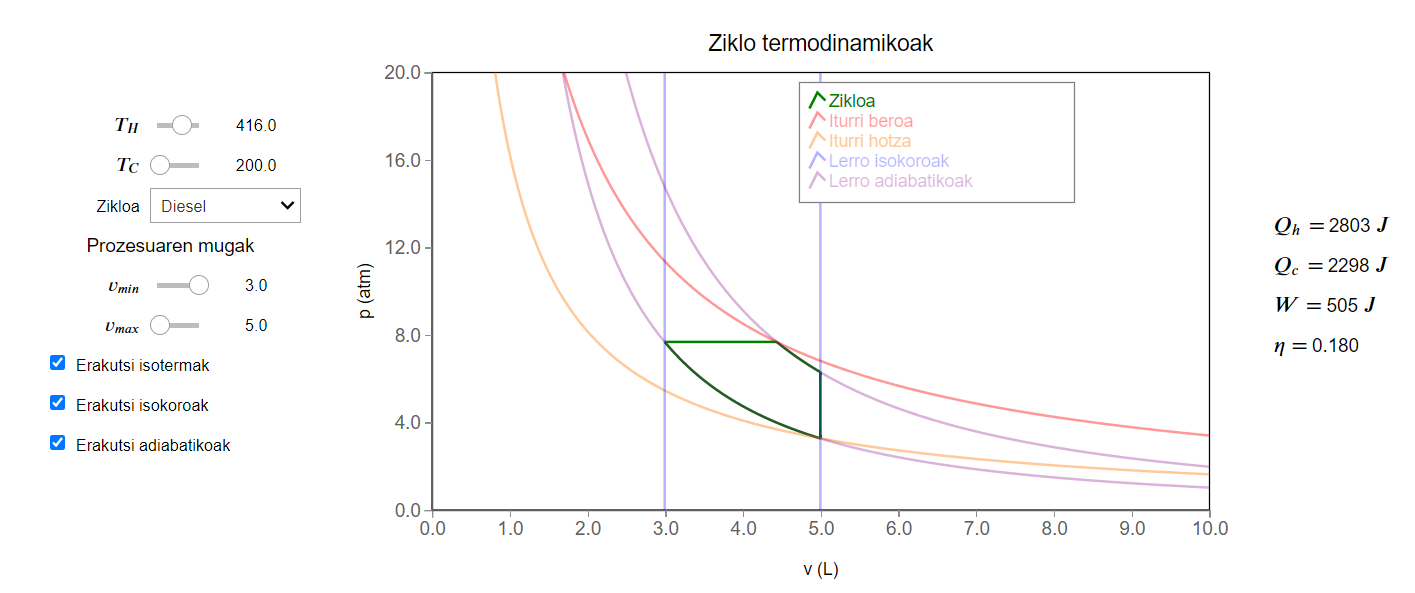

In [2]:
from IPython.display import Image
Image(filename='../../static/images/apps/ideal_gas/124-000.png')

## CSS

A custom `css` file is used to improve the interface of this application. It can be found [here](https://github.com/jongablop/MinervaLab/blob/master/static/custom.css).

In [ ]:
from IPython.display import HTML
display(HTML("<head><link rel='stylesheet' type='text/css' href='./../../static/custom.css'></head>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

## Packages

In [ ]:
import numpy as np

import bqplot as bq
import bqplot.marks as bqm
import bqplot.scales as bqs
import bqplot.axes as bqa

import ipywidgets as widgets

## Physical functions

This are the functions that have a physical meaning:
- `get_vertices_stirling`
- `get_vertices_diesel`
- `get_vertices_carnot`
- `get_path`
- `get_isotherm`
- `get_adiabatic`
- `get_work`
- `get_energy_change`

In [ ]:
def get_vertices_stirling(Th, Tc, v_max, v_min):
    '''
    This function calculates the four vertices for a Stirling
    cycle between focuses Tc and Th and within volume range
    (v_min,v_max).
    
    Inputs:
    Th: float value for hot focus temperature (in K)'
    Tc: float value for cold focues temperature (in K) 
    v_max: float value for maximun allowed volume (in L)
    v_min: float value for minimun allowed volume (in L)
    
    Returns:
    v: list of float values for vertex volumes (in L)
    p: list of float values for vertex pressures (in atm)
    '''
    
    v = [v_max, v_min, v_min, v_max]
    p = [N*R*Tc/v[0], N*R*Tc/v[1], N*R*Th/v[2], N*R*Th/v[3]]
    Cycle_001.possible = True  # Stirling cycles are always possible
    Cycle_001.opacities =[1.0] 
    return v, p    

In [ ]:
def get_vertices_diesel(Th, Tc, v_max, v_min):
    '''
    This function calculates the four vertices for a Diesel
    cycle between focuses Tc and Th and within volume range
    (v_min,v_max). If the process is not possible within the
    given values, it returns a dummy curve and hides the 
    cycle plot.
    
    Inputs:
    Th: float value for hot focus temperature (in K)'
    Tc: float value for cold focues temperature (in K) 
    v_max: float value for maximun allowed volume (in L)
    v_min: float value for minimun allowed volume (in L)
    
    Returns:
    v: list of float values for vertex volumes (in L)
    p: list of float values for vertex pressures (in atm)
    '''
        
    v = [v_max, v_min, 0.0, v_max]
    p = [N*R*Tc/v[0], 0.0, 0.0, 0.0]
    
    p[1] = p[0] * (v[0]/v[1])**gamma
    p[2] = p[1]
    v[2] = N*R*Th/p[2]
    p[3] = p[2] * (v[2]/v[3])**gamma
    Cycle_001.possible = True
    Cycle_001.opacities=[1.0]  # Show cycle when possible
    
    if p[3] > p[2] or p[3] < p[0]:
        # Case: Diesel cycle is impossible within limits
        v=[v_max,v_max,v_min,v_min]
        p=[N*R*Tc/v_max, N*R*Tc/v_max, N*R*Th/v_min, N*R*Th/v_min]
        Cycle_001.possible = False
        Cycle_001.opacities=[0.0]  # Hide cycle when impossible
    
    return v, p

In [ ]:
def get_vertices_carnot(Th, Tc, v_max, v_min):
    '''
    This function calculates the four vertices for a Carnot
    cycle between focuses Tc and Th and within volume range
    (v_min,v_max). If the process is not possible within the
    given values, it returns a dummy curve and hides the 
    cycle plot.
    
    Inputs:
    Th: float value for hot focus temperature (in K)'
    Tc: float value for cold focues temperature (in K) 
    v_max: float value for maximun allowed volume (in L)
    v_min: float value for minimun allowed volume (in L)
    
    Returns:
    v: list of float values for vertex volumes (in L)
    p: list of float values for vertex pressures (in atm)
    '''

    v = [v_max, 0.0, v_min, 0.0]
    p = [N*R*Tc/v[0], 0.0, N*R*Th/v[2], 0.0]
    
    v[1] = (v[2]**gamma/v[0] * p[2]/p[0])**(1.0/(gamma-1.0))
    p[1] = N*R*Tc/v[1] 
    v[3] = (v[0]**gamma/v[2] * p[0]/p[2])**(1.0/(gamma-1.0))                
    p[3] = N*R*Th/v[3]
    Cycle_001.possible = True
    Cycle_001.opacities=[1.0]  # Show cycle when possible
        
    if v[0] <= v[1]:
        # Case: Carnot cycle is impossible within limits
        v = [v_max, v_max, v_min, v_min]
        p = [N*R*Tc/v_max, N*R*Tc/v_max, N*R*Th/v_min, N*R*Th/v_min]
        Cycle_001.possible = False
        Cycle_001.opacities=[0.0]  # Hide cycle when impossible
    
    return v, p

In [ ]:
def get_path(vi,pi,vf,pf):
    '''
    This function calculates a polytropic path between
    to given points in a pv plane.
    
    Inputs:
    vi: float value for initial point volume (in L)
    pi: float value for initial point pressure (in atm)
    vf: float value for final point volume (in L)
    pf: float value for final point pressure (in atm)
    
    Returns:
    v_values: 1darray with float values for volumes (in L)
    p_values: 1darray with float values for pressures (in atm)
    '''

    v_values = np.linspace(vi,vf,pts)
    p_values = np.empty((pts))
    
    if abs(vf-vi) < 0.01:  # Isochoric case
        p_values = np.linspace(pi,pf,pts)
    else:
        j = np.log(pi/pf)/np.log(vf/vi)
        for i in range(pts): 
            p_values[i] = pi * (vi/v_values[i])**j

    return v_values, p_values

In [ ]:
def get_isotherm(T):
    '''
    This function calculates the (v,p) coordinates
    for a isotherm with termperature T.
    
    Inputs:
    T: float values for temperature (in K)
    
    Returns:
    v_values: 1darray with float values for volumes (in L)
    p_values: 1darray with float values for pressures (in atm)
    '''
    
    v_values = np.linspace(v_min, v_max, pts)
    p_values = np.empty((pts))
    
    for i in range(pts):
        p_values[i]  = N*R*T/v_values[i]
            
    return v_values, p_values
    

In [ ]:
def get_adiabatic(vi,pi):
    '''
    This function calculates the (v,p) coordinates
    for a adiabatic curve that passes through point
    (vi,pi)
    
    Inputs:
    vi: float value for given point volume (in L)
    pi: float value for given point pressure (in atm)
    
    Returns:
    v_values: 1darray with float values for volumes (in L)
    p_values: 1darray with float values for pressures (in atm)
    '''
    
    v_values = np.linspace(v_min,v_max,pts)
    p_values = np.empty((pts))
    
    for i in range(pts): 
        p_values[i] = pi * (vi/v_values[i])**gamma

    return v_values, p_values

In [ ]:
def get_work(v_values, p_values):
    '''
    This function calculates the work done in a process
    described by the point arrays v_values, p_values by
    applying numerical integration.
    
    Inputs:
    v_values: 1darray with the v coordinates of the curve (in L)
    p_values: 1darray with the p coordinates of the curve (in atm)
    
    Returns:
    W: float value for the work done (in J)
    '''

    W = 0.0
    dv = (v_values[pts-1] - v_values[0]) / pts
    for i  in range(pts):
        v = v_values[i]
        p = p_values[i]
        W = W - p*dv
    W = C*W    # Convert W form atm*L to J
    return W

In [ ]:
def get_energy_change(vi, pi, vf, pf, gamma):
    '''
    This function calculates the internal energy change of a process
    starting at (vi,pi) and ending at (vf,pf).
    
    Inputs:
    vi: float value for initial point volume (in L)
    pi: float value for initial point pressure (in atm)
    vf: float value for final point volume (in L)
    pf: float value for final point pressure (in atm)
    
    Returns
    dU: float value for the energy change (in J)
    '''

    Cv = 1.0 / (gamma-1.0) #Adimensional value of Cv (Cv/NR indeed)
    dU = C * Cv*(vf*pf - vi*pi) # Energy difference in Joules
    return dU

## Functions related to the interaction

In [ ]:
def get_cycle(v_vertices, p_vertices):
    '''
    This function constructs the x and y attributes of the
    Cycle_001 mark, which controls the plot of the cycle.
    
    Inputs:
    v_vertices: list of float values for vertex volumes (in L)
    p_vertices: list of float values for vertex pressures (in atm)
    
    Returns:
    x_values: array of shape (4,pts) for volume coordinates (in L)
    y_values: array of shape (4,pts) for pressure coordinates (in atm)
    '''

    # Define empty arrays
    x_values = np.empty((4,pts))
    y_values = np.empty((4,pts))
    
    # First 3 subprocesses
    for i in range(3):  
        v_values, p_values = get_path(v_vertices[i], p_vertices[i], v_vertices[i+1], p_vertices[i+1])
        x_values[i] = v_values
        y_values[i] = p_values
        
    # Fourth subprocess (from vertex 3 to vertex 0)
    v_values, p_values = get_path(v_vertices[3], p_vertices[3], v_vertices[0], p_vertices[0])
    x_values[3] = v_values
    y_values[3] = p_values

    return x_values, y_values

In [ ]:
def update_volume_labels(process):
    '''
    This function updates the text shown above the
    v sliders to match the physical meaning.
    
    Inputs:
    process: string describing the type of cycle
    '''
    
    if process == 'Stirling':
        volume_text.value = 'Isokoroen balioak'
    elif process == 'Diesel':
        volume_text.value = 'Prozesuaren mugak'
    elif process == 'Carnot':
        volume_text.value = 'Prozesuaren mugak'

In [ ]:
def update_energies(x_values, y_values):
    '''
    This function calculates and outputs the Qh, Qc
    and W parameters for the whole cycle. It also
    gives the efficacy of the cycle.
    
    Inputs:
    x_values: array of shape (4,pts) for volume coordinates (in L)
    y_values: array of shape (4,pts) for pressure coordinates (in atm)
    '''
    
    # Define empty integrands
    Q_h = 0.0
    Q_c = 0.0
    W = 0.0

    # For each process sum results to integrands
    for i in range(4):
        v_values = x_values[i]
        p_values = y_values[i]
        W_process = get_work(v_values, p_values)
        dU_process = get_energy_change(v_values[0], p_values[0], v_values[pts-1], p_values[pts-1], gamma)
        Q_process = dU_process - W_process
        
        W = W + W_process        
        if i == 0 or i == 3:
            Q_c = Q_c + Q_process
        else:
            Q_h = Q_h + Q_process
        
        
    # Convert to absolute values
    Q_h = abs(Q_h)
    Q_c = abs(Q_c)
    W = abs(W)
    
    # Calculate efficiency
    eta = W/Q_h
    
    # Assign 0 to impossible cycles
    if not Cycle_001.possible:
        Q_h = 0.0
        Q_c = 0.0
    
    # Update labels
    Qh_text.value = '%.0f' % Q_h
    Qc_text.value ='%.0f' % Q_c
    W_text.value ='%.0f' % W
    eta_text.value = '%.3f' % eta

In [ ]:
def update_cycle(v_vertices, p_vertices):
    '''
    This function updates the plot of the cycle
    when needed.
    
    Inputs:
    v_vertices: list of float values for vertex volumes (in L)
    p_vertices: list of float values for vertex pressures (in atm)
    '''
    
    # Calculate the x and y objects
    x_values, y_values = get_cycle(v_vertices, p_vertices)
    
    # Update the marks
    Cycle_001.x = x_values
    Cycle_001.y = y_values
    
    # Update the energies
    update_energies(x_values, y_values)

In [ ]:
def update_isochores(vi,vf):
    '''
    This function updates the plot of the
    isochoric curves for the minimun and maximun
    volume points.
    
    Inputs:
    vi: float value for initial volume (in L)
    vf: float value for final volume (in L)
    '''
    
    # Update the plots
    IsochoreMin_001.x = np.full(2,vi)
    IsochoreMin_001.y = np.linspace(p_min, p_max, 2)
    IsochoreMax_001.x = np.full(2,vf)
    IsochoreMax_001.y = np.linspace(p_min, p_max, 2)

In [ ]:
def update_adiabatics(vi,pi,vf,pf):
    '''
    This function updates the plot of the
    adiabatic curves for the minimun and maximu
    volume points.
    
    Inputs:
    vi: float value for initial volume (in L)
    pi: float value for initial pressure (in atm)
    vf: float value for final volume (in L)
    pf: float value for final pressure (in atm)
    '''
    
    # Calculate the curves
    x1_values, y1_values = get_adiabatic(vi,pi)
    x2_values, y2_values = get_adiabatic(vf,pf)

    # Update the plots
    AdiabaticMin_001.x = x1_values
    AdiabaticMin_001.y = y1_values
    AdiabaticMax_001.x = x2_values
    AdiabaticMax_001.y = y2_values

In [ ]:
def update_cycle_legend():
    '''
    This function moves the first subprocess of
    the cycle to a new mark when the process is 
    allowed. This is needed to avoid legend shown
    four times for the porcess.
    '''

    opacities=Cycle_001.opacities
    if abs(opacities[0]-1.0)<0.01:  # Only needed if curve is visible
        x_values = Cycle_001.x
        y_values = Cycle_001.y
        CycleLegend_001.x = x_values[0]
        CycleLegend_001.y = y_values[0]
        CycleLegend_001.opacities=[1.0]
        opacities=[0.0,1.0,1.0,1.0]
        Cycle_001.opacities=opacities
        
    else:  # If curve is not allowed this is not needed
        CycleLegend_001.opacities=[0.0]

In [ ]:
def update_points(change):
    '''
    This function recalculates all parameters and replots
    everything whenever a widget changes it's value.
    '''
    
    # Read the widgets
    vi = vi_slider.value
    vf = vf_slider.value
    Tc = Tc_slider.value
    Th = Th_slider.value
    process = process_dropdown.value
    
    # Get the vertices
    if process == 'Stirling':
        v_vertices, p_vertices = get_vertices_stirling(Th, Tc, vf, vi)
    elif process == 'Diesel':
        v_vertices, p_vertices = get_vertices_diesel(Th, Tc, vf, vi)     
    elif process == 'Carnot':
        v_vertices, p_vertices = get_vertices_carnot(Th, Tc, vf, vi)
    
    # Update the outputs
    update_isochores(vi,vf)
    update_adiabatics(v_vertices[0],p_vertices[0], v_vertices[2], p_vertices[2])
    update_cycle(v_vertices, p_vertices)
    update_cycle_legend()
    update_volume_labels(process)

In [ ]:
def update_isotherms(change):
    '''
    This function updates the isotherm
    plots when temperatures are changed.
    '''
    
    # Read the widgets
    Th = Th_slider.value
    Tc = Tc_slider.value
    
    # Create empty array
    x_values = np.empty((2,pts))
    y_values = np.empty((2,pts))
    
    # Append hot isotherm to array
    v_values, p_values = get_isotherm(Th)
    x_values[0] = v_values
    y_values[0] = p_values
    
    # Append cold isotherm to array
    v_values, p_values = get_isotherm(Tc)
    x_values[1] = v_values
    y_values[1] = p_values
    
    # Update the plot
    Isotherms_001.x = x_values
    Isotherms_001.y = y_values
    
    # Update the process
    update_points(None)

In [ ]:
def show_isocurves(change):
    '''
    This function controls the visibility of the isotherms,
    isochores and adiabatics depending on the values of the
    checkboxes.
    '''
    
    Isotherms_001.visible = show_isotherms_check.value
    IsochoreMin_001.visible = show_isochores_check.value
    IsochoreMax_001.visible = show_isochores_check.value
    AdiabaticMin_001.visible = show_adiabatics_check.value
    AdiabaticMax_001.visible = show_adiabatics_check.value

## Main interface

In [ ]:
#######################
###   PARAMETERS    ###
#######################

## Global Parameters

N = 1.0
R = 0.082057 # Ideal gas constant in atm*L/mol/K
C = 101.325 # Conversion factor from atm*L to J -> C = J/atmL
pts = 1000 # Number of points for plotting each process
gamma = 5.0/3.0 # Adiabatic index. For a monoatomic gas: 5/3

## Limits of parameters (volumes in L, pressures in atm)

# Limits of the figure
v_min = 0.01
v_max = 10.0
p_min = 0.01
p_max = 20.0

# Limits of the sliders
Th_min = 300.0
Th_max = 500.0
Tc_min = 200.0
Tc_max = 300.0
v_min_lowerbound = 1.0
v_min_upperbound = 3.0
v_max_lowerbound = 5.0
v_max_upperbound = 8.0

# Initial values
vi = 3.0
vf = 5.0
Tc = 200.0
Th = 400.0
gamma = 5.0/3.0 # Adiabatic index (5/3 for monoatomic gases, 7/5 for diatomic gases at room temperature)
N = 1.0 # Number of mols of gas

########################
###CREATE THE FIGURES###
########################

fig_124_001 = bq.Figure(title='Ziklo termodinamikoak',
                marks=[],
                axes=[],
                padding_x=0.0,
                padding_y=0.0,
                animation_duration=0,
                legend_location='top-right',
                legend_style= {'fill': 'white', 'stroke': 'grey'},
                background_style= {'fill': 'white',  'stroke': 'black'},
                fig_margin=dict(top=70, bottom=60, left=80, right=30),
                toolbar = True,
                layout=widgets.Layout(width='95%')
    )


scale_x = bqs.LinearScale(min = v_min, max = v_max, allow_padding = False)
scale_y = bqs.LinearScale(min = p_min, max = p_max, allow_padding = False)

axis_x = bqa.Axis(scale=scale_x,
                tick_format='.1f',#'0.2f',
                tick_style={'font-size': '15px'},
                tick_values = np.linspace(v_min, v_max, 11),
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                label='v (L)',
                label_location='middle',
                label_style={'stroke': 'black', 'default-size': 35},
                label_offset='50px')

axis_y = bqa.Axis(
                scale=scale_y,
                tick_format='.1f',#'0.2f',
                tick_style={'font-size': '15px'},
                tick_values= np.linspace(p_min, p_max, 6),
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                orientation='vertical',
                label='p (atm)',
                label_location='middle',
                label_style={'stroke': 'red', 'default_size': 35},
                label_offset='50px')

fig_124_001.axes = [axis_x,axis_y]

########################
####CREATE THE MARKS####
########################

Cycle_001 = bqm.Lines(
                x = [], 
                y = [], 
                scales = {'x': scale_x, 'y': scale_y},
                display_legend=False,
                colors = ['green'],
                possible = True,
)

CycleLegend_001 = bqm.Lines(
                x = [], 
                y = [], 
                scales = {'x': scale_x, 'y': scale_y},
                display_legend=True,
                colors = ['green'],
                labels=['Zikloa'],
)

Isotherms_001 = bqm.Lines(
                x = [], 
                y = [], 
                scales = {'x': scale_x, 'y': scale_y},
                display_legend=True,
                labels = ["Iturri beroa", "Iturri hotza"],
                colors = ['#FF0000', '#FF7700'],
                opacities = [0.4]
)

IsochoreMin_001 = bqm.Lines(
                x = [],
                y = [],
                scales = {'x': scale_x, 'y': scale_y},
                display_legend=True,
                labels = ["Lerro isokoroak"],
                colors = ['blue'],
                opacities = [0.3],
)

IsochoreMax_001 = bqm.Lines(
                x = [],
                y = [],
                scales = {'x': scale_x, 'y': scale_y},
                display_legend=False,
                colors = ['blue'],
                opacities = [0.3],
)

AdiabaticMin_001 = bqm.Lines(
                x = [],
                y = [],
                scales = {'x': scale_x, 'y': scale_y},
                display_legend=True,
                labels = ["Lerro adiabatikoak"],
                colors = ['purple'],
                opacities = [0.3],
)

AdiabaticMax_001 = bqm.Lines(
                x = [],
                y = [],
                scales = {'x': scale_x, 'y': scale_y},
                display_legend=False,
                colors = ['purple'],
                opacities = [0.3],
)


fig_124_001.marks = [Cycle_001, CycleLegend_001, Isotherms_001, IsochoreMin_001, IsochoreMax_001, AdiabaticMin_001, AdiabaticMax_001]

########################
######  WIDGETS  #######
########################

Th_slider = widgets.FloatSlider(
    value=Th,
    min=Th_min,
    max=Th_max,
    step=2,
    description='$T_H$',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=widgets.Layout(width='95%'),
)

Th_slider.observe(update_isotherms, 'value')

Tc_slider = widgets.FloatSlider(
    value=Tc,
    min=Tc_min,
    max=Tc_max,
    step=2,
    description='$T_C$',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=widgets.Layout(width='95%'),
)

Tc_slider.observe(update_isotherms, 'value')

process_dropdown = widgets.Dropdown(
    options=['Stirling', 'Diesel', 'Carnot'],
    value='Stirling',
    description='Zikloa',
    disabled=False,
    layout=widgets.Layout(width='95%')
)

process_dropdown.observe(update_points, 'value')



vi_slider = widgets.FloatSlider(
    value=vi,
    min=v_min_lowerbound,
    max=v_min_upperbound,
    step=0.1,
    description='$v_{min}$',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=widgets.Layout(width='95%'),
)

vi_slider.observe(update_points, 'value')

vf_slider = widgets.FloatSlider(
    value=vf,
    min=v_max_lowerbound,
    max=v_max_upperbound,
    step=0.1,
    description='$v_{max}$',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=widgets.Layout(width='95%'),
)

vf_slider.observe(update_points, 'value')

show_isotherms_check = widgets.Checkbox(
    description='Erakutsi isotermak',
    disabled=False,
    value=True,
    layout=widgets.Layout(width='95%')
)

show_isotherms_check.observe(show_isocurves, 'value')

show_isochores_check = widgets.Checkbox(
    description='Erakutsi isokoroak',
    disabled=False,
    value=True,
    layout=widgets.Layout(width='95%')
)

show_isochores_check.observe(show_isocurves, 'value')

show_adiabatics_check = widgets.Checkbox(
    description='Erakutsi adiabatikoak',
    disabled=False,
    value=True,
    layout=widgets.Layout(width='95%')
)

show_adiabatics_check.observe(show_isocurves, 'value')


########################
######  LABELS  ########
########################

Qh_text = widgets.Label(value='')
Qc_text = widgets.Label(value='')
W_text = widgets.Label(value='')
eta_text = widgets.Label(value='')
volume_text = widgets.Label(value='')


########################
######   INIT   ########
########################

update_isotherms(None)


########################
######  LAYOUT  ########
########################


# Left Block ##
left_block_124_000 = widgets.VBox([], layout=widgets.Layout(width='20%', align_items='center'))
left_block_124_000.children = [Th_slider, Tc_slider, process_dropdown, volume_text, vi_slider, vf_slider,
                               show_isotherms_check, show_isochores_check, show_adiabatics_check]
                              
## Center Block ##
center_block_124_000 = widgets.VBox([], layout=widgets.Layout(width='70%', align_items='center'))
center_block_124_000.children = [fig_124_001]

## Right Block ##
right_block_124_000 = widgets.VBox([], layout=widgets.Layout(width='10%', align_items='center'))
right_block_124_000.children = [
                                widgets.HBox([widgets.Label(value='$Q_h=$'),Qh_text,widgets.Label(value='$J$')], layout=widgets.Layout(width='100%')),
                                widgets.HBox([widgets.Label(value='$Q_c=$'),Qc_text,widgets.Label(value='$J$')], layout=widgets.Layout(width='100%')),
                                widgets.HBox([widgets.Label(value='$W=$'),W_text,widgets.Label(value='$J$')], layout=widgets.Layout(width='100%')),
                                widgets.HBox([widgets.Label(value='$\eta =$'),eta_text], layout=widgets.Layout(width='100%'))
                               ]

## Main Block ##

main_block_124_000 = widgets.HBox([],layout=widgets.Layout(width='100%', align_items='center'))
main_block_124_000.children = [left_block_124_000, center_block_124_000, right_block_124_000]

main_block_124_000